In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from vivarium import InteractiveContext, Artifact

from datetime import datetime, timedelta
from pathlib import Path
import itertools
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd, numpy as np
pd.set_option('display.max_rows', 60)

import numpy as np
import researchpy as rp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import scipy.stats

from db_queries import get_outputs as go
from db_queries import get_ids
from get_draws.api import get_draws

## Load in Data and First Time Step

In [2]:
path = Path('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')
path

PosixPath('/ihme/homes/lutzes/vivarium_nih_us_cvd/src/vivarium_nih_us_cvd/model_specifications/nih_us_cvd.yaml')

In [3]:
sim = InteractiveContext(Path(path), setup=False)
sim.configuration.update({
                          'population':
                              {'population_size': 50_000,
                              },
                          'time':
                              {'start':
                                  {'year': 2023
                                  }
                              }
                          }
                        )
sim.setup()

2023-07-25 11:38:03.631 | INFO     | simulation_1-artifact_manager:66 - Running simulation from artifact located at /mnt/team/simulation_science/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf.
2023-07-25 11:38:03.633 | INFO     | simulation_1-artifact_manager:67 - Artifact base filter terms are ['draw == 0'].
2023-07-25 11:38:03.637 | INFO     | simulation_1-artifact_manager:68 - Artifact additional filter terms are None.


In [4]:
pop0 = sim.get_population()
pop0.head()

,tracked,exit_time,sex,alive,entrance_time,location,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,outreach,ldlc_medication,sbp_medication_adherence,sbp_medication,ldlc_multiplier,ldlc_medication_adherence,polypill,visit_type,last_fpg_test_date,scheduled_date
0,True,NaT,Female,alive,2022-12-04,Alabama,7.004023,not_dead,0.0,0.0,...,cat2,no_treatment,cat3,no_treatment,1.000,cat3,cat2,none,NaT,NaT
1,True,NaT,Male,alive,2022-12-04,Alabama,66.517368,not_dead,0.0,0.0,...,cat2,medium_intensity,cat3,no_treatment,1.362,cat3,cat2,none,NaT,NaT
2,True,NaT,Male,alive,2022-12-04,Alabama,40.859520,not_dead,0.0,0.0,...,cat2,no_treatment,cat2,no_treatment,1.000,cat3,cat2,none,NaT,NaT
3,True,NaT,Female,alive,2022-12-04,Alabama,14.248124,not_dead,0.0,0.0,...,cat2,no_treatment,cat3,no_treatment,1.000,cat1,cat2,none,NaT,NaT
4,True,NaT,Male,alive,2022-12-04,Alabama,41.302116,not_dead,0.0,0.0,...,cat2,no_treatment,cat1,one_drug_half_dose_efficacy,1.000,cat2,cat2,none,NaT,NaT


In [5]:
#pop0.columns

In [6]:
#sim.list_values()

In [7]:
data1 = pd.concat([pop0,
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                  ], axis=1)
data1.head()

,tracked,exit_time,sex,alive,entrance_time,location,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,ldlc_multiplier,ldlc_medication_adherence,polypill,visit_type,last_fpg_test_date,scheduled_date,high_ldl,high_sbp,high_bmi,high_fpg
0,True,NaT,Female,alive,2022-12-04,Alabama,7.004023,not_dead,0.0,0.0,...,1.000,cat3,cat2,none,NaT,NaT,0.000000,50.000000,5.000000,1.000000
1,True,NaT,Male,alive,2022-12-04,Alabama,66.517368,not_dead,0.0,0.0,...,1.362,cat3,cat2,none,NaT,NaT,3.412406,142.043833,22.399923,5.646072
2,True,NaT,Male,alive,2022-12-04,Alabama,40.859520,not_dead,0.0,0.0,...,1.000,cat3,cat2,none,NaT,NaT,3.029555,110.858354,28.737546,5.309503
3,True,NaT,Female,alive,2022-12-04,Alabama,14.248124,not_dead,0.0,0.0,...,1.000,cat1,cat2,none,NaT,NaT,0.000000,50.000000,5.000000,1.000000
4,True,NaT,Male,alive,2022-12-04,Alabama,41.302116,not_dead,0.0,0.0,...,1.000,cat2,cat2,none,NaT,NaT,2.377483,146.671725,27.439364,5.440486


In [8]:
data1 = data1.loc[(data1.age > 25) & (data1.alive == 'alive')]
data1['age_start'] = ((data1.age/5).astype(int) * 5).astype(float)

## Testing For Correlation Between Exposure Values

In [9]:
## Starting with the NOT age specific correlation testing 

# SBP/LDL-C, SBP/FPG, LDL-C/BMI, and FPG/BMI
sbp_ldl, pval = scipy.stats.spearmanr(data1['high_sbp'], data1['high_ldl'])
sbp_fpg, pval = scipy.stats.spearmanr(data1['high_sbp'], data1['high_fpg'])
ldl_bmi, pval = scipy.stats.spearmanr(data1['high_ldl'], data1['high_bmi'])
bmi_fpg, pval = scipy.stats.spearmanr(data1['high_bmi'], data1['high_fpg'])

print(sbp_ldl, sbp_fpg, ldl_bmi, bmi_fpg)  

0.1297776579501577 0.3093726704900217 0.10619974269834848 0.2511029344818093


In [10]:
correlation = pd.read_csv('/ihme/homes/lutzes/correlation.csv')
correlation = correlation.drop('Unnamed: 0',axis=1)
correlation

,age_start,age_end,sbp_ldl,sbp_ldl_pval,sbp_bmi,sbp_bmi_pval,ldl_bmi,ldl_bmi_pval,sbp_fpg,sbp_fpg_pval,ldl_fpg,ldl_fpg_pval,bmi_fpg,bmi_fpg_pval
0,25,30,0.124353,1.754506e-104,0.254368,1.150079e-69,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
1,30,35,0.124353,1.754506e-104,0.291779,2.449877e-92,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
2,35,40,0.124353,1.754506e-104,0.312886,3.072652e-102,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
3,40,45,0.124353,1.754506e-104,0.281782,1.226712e-82,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
4,45,50,0.124353,1.754506e-104,0.215524,2.552392e-42,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
5,50,55,0.124353,1.754506e-104,0.157363,2.713152e-23,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
6,55,60,0.124353,1.754506e-104,0.126155,5.105869e-13,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
7,60,65,0.124353,1.754506e-104,0.046018,2.217365e-03,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
8,65,70,0.124353,1.754506e-104,0.044023,9.283694e-03,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0
9,70,75,0.124353,1.754506e-104,0.000000,2.296363e-01,0.111832,3.384224e-86,0.338096,0,0,NaN,0.294275,0


In [12]:
## Now for SBP and BMI which is actually age specific! 
sbp_bmi_ages = pd.DataFrame()
for i in range(len(correlation)):
    age = correlation.iloc[i,0]
    subdata = data1.loc[data1.age_start==age]
    bmi_sbp, pval = scipy.stats.spearmanr(subdata['high_sbp'], subdata['high_bmi'])
    small_data = pd.DataFrame([age,bmi_sbp,pval]).transpose()
    sbp_bmi_ages = pd.concat([sbp_bmi_ages, small_data], ignore_index=True)
sbp_bmi_ages = sbp_bmi_ages.rename(columns={0: 'age', 1:'corr', 2:'pval'})
sbp_bmi_ages.head()

,age,corr,pval
0,25.0,0.225022,1.090201e-43
1,30.0,0.250433,6.783448e-50
2,35.0,0.217423,6.303031e-38
3,40.0,0.244981,3.221074e-45
4,45.0,0.231894,2.925837e-42


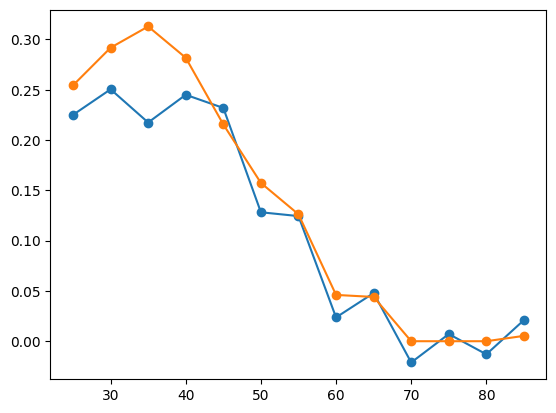

In [13]:
plt.figure() 
plt.plot(sbp_bmi_ages['age'], sbp_bmi_ages['corr'], marker='o')
plt.plot(correlation['age_start'], correlation['sbp_bmi'], marker='o')

## Lastly, going to test this again after some time and see how it holds up! 

In [14]:
sim_data = pd.DataFrame()
for step in list(range(0,25)):
    sim.step()
    pop_t = sim.get_population()
    data_t = pd.concat([pop_t, 
                   sim.get_value('high_ldl_cholesterol.exposure')(pop0.index).rename('high_ldl'),
                   sim.get_value('high_systolic_blood_pressure.exposure')(pop0.index).rename('high_sbp'),
                   sim.get_value('high_body_mass_index_in_adults.exposure')(pop0.index).rename('high_bmi'),
                   sim.get_value('high_fasting_plasma_glucose.exposure')(pop0.index).rename('high_fpg'),
                       ],axis=1)
    data_t['step'] = step
    print(step)
    sim_data = pd.concat([sim_data, data_t])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [15]:
last_step = sim_data.loc[(sim_data.step==24) & (sim_data.age > 25) & (sim_data.alive == 'alive')]
last_step['age_start'] = ((last_step.age/5).astype(int) * 5).astype(float)
last_step.head()

,tracked,exit_time,sex,alive,entrance_time,location,age,cause_of_death,years_of_life_lost,years_lived_with_disability,...,polypill,visit_type,last_fpg_test_date,scheduled_date,high_ldl,high_sbp,high_bmi,high_fpg,step,age_start
1,True,NaT,Male,alive,2022-12-04,Alabama,68.433864,not_dead,0.0,0.000000,...,cat2,none,NaT,2025-03-02 06:04:18.644620800,3.412406,142.043833,22.399923,5.646072,24,65.0
2,True,NaT,Male,alive,2022-12-04,Alabama,42.776015,not_dead,0.0,0.000000,...,cat2,background,2024-01-28,NaT,3.029555,110.858354,28.737546,5.309503,24,40.0
4,True,NaT,Male,alive,2022-12-04,Alabama,43.218612,not_dead,0.0,0.000000,...,cat2,scheduled,2023-04-23,2025-05-27 20:43:55.943443200,2.377483,146.671725,27.439364,5.440486,24,40.0
5,True,NaT,Male,alive,2022-12-04,Alabama,31.401712,not_dead,0.0,0.000000,...,cat2,none,NaT,NaT,2.954992,142.219910,25.211496,3.834926,24,30.0
7,True,NaT,Female,alive,2022-12-04,Alabama,67.252531,not_dead,0.0,0.461943,...,cat2,none,2023-06-18,2025-03-18 05:37:09.643123200,3.821880,140.632643,36.413314,9.743708,24,65.0


In [16]:
## Starting with the NOT age specific correlation testing 

# SBP/LDL-C, SBP/FPG, LDL-C/BMI, and FPG/BMI
sbp_ldl, pval = scipy.stats.spearmanr(last_step['high_sbp'], last_step['high_ldl'])
sbp_fpg, pval = scipy.stats.spearmanr(last_step['high_sbp'], last_step['high_fpg'])
ldl_bmi, pval = scipy.stats.spearmanr(last_step['high_ldl'], last_step['high_bmi'])
bmi_fpg, pval = scipy.stats.spearmanr(last_step['high_bmi'], last_step['high_fpg'])

print(sbp_ldl, sbp_fpg, ldl_bmi, bmi_fpg)  

0.06195691977853741 0.30178415222808697 0.11248508082417237 0.24885560964686781


In [17]:
## Now for SBP and BMI which is actually age specific! 
sbp_bmi_ages = pd.DataFrame()
for i in range(len(correlation)):
    age = correlation.iloc[i,0]
    subdata = last_step.loc[last_step.age_start==age]
    bmi_sbp, pval = scipy.stats.spearmanr(subdata['high_sbp'], subdata['high_bmi'])
    small_data = pd.DataFrame([age,bmi_sbp,pval]).transpose()
    sbp_bmi_ages = pd.concat([sbp_bmi_ages, small_data], ignore_index=True)
sbp_bmi_ages = sbp_bmi_ages.rename(columns={0: 'age', 1:'corr', 2:'pval'})
sbp_bmi_ages.head()

,age,corr,pval
0,25.0,0.233169,2.555097e-46
1,30.0,0.232150,3.369927e-43
2,35.0,0.216707,5.891792e-38
3,40.0,0.256878,3.743250e-50
4,45.0,0.252615,1.770557e-48


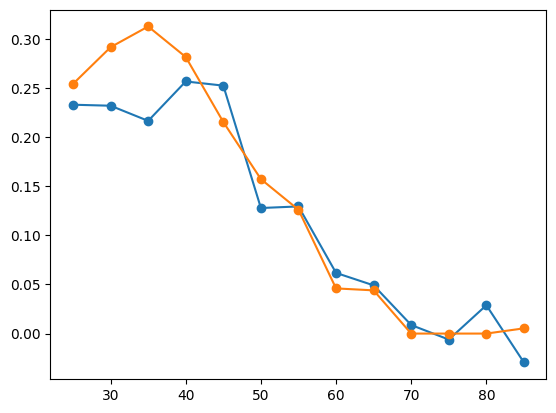

In [18]:
plt.figure() 
plt.plot(sbp_bmi_ages['age'], sbp_bmi_ages['corr'], marker='o')
plt.plot(correlation['age_start'], correlation['sbp_bmi'], marker='o')